In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.078.h5ad')
adata.var_names_make_unique()
adata.obs['type']='Pre-training data'

In [5]:
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

In [6]:
k=16
graph = prepare_inputs(adata, k, device)

In [7]:
in_channels = graph.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.30it/s, Epoch=199, Loss=0.9014]


In [9]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [10]:
adata.obsm['SpaLP']=embedding

In [11]:
torch.save(model.state_dict(), "/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/78_pretrian_model.pth")

In [12]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/Pre-training.h5ad',compression='gzip')

In [14]:
from SpaLP.utils import transfer_labels_by_cosine

In [15]:
adata1=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.076.h5ad')
adata1.var_names_make_unique()
adata1.obs['type']='Inference data1'

adata2=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.077.h5ad')
adata2.var_names_make_unique()
adata2.obs['type']='Inference data2'

In [16]:
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X

sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [17]:
graph1 = prepare_inputs(adata1, k=16, device=device)
graph2 = prepare_inputs(adata2, k=16, device=device)

In [18]:
in_channels = graph1.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/78_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph1.features, graph1.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata1.obsm['SpaLP']=embedding

In [19]:
in_channels = graph2.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=32).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/78_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph2.features, graph2.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata2.obsm['SpaLP']=embedding

In [20]:
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/Pre-training.h5ad')

In [21]:
Pre_train_data

AnnData object with n_obs × n_vars = 45393 × 1122
    obs: 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'slice', 'type'
    var: 'gene_name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'mean', 'std'
    uns: 'citation', 'major_brain_region_colors', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'SpaLP', 'X_CCF', 'X_spatial_coords',

In [22]:
adata1=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata1,label_key='major_brain_region',embedding_key='SpaLP')
adata2=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata2,label_key='major_brain_region',embedding_key='SpaLP')

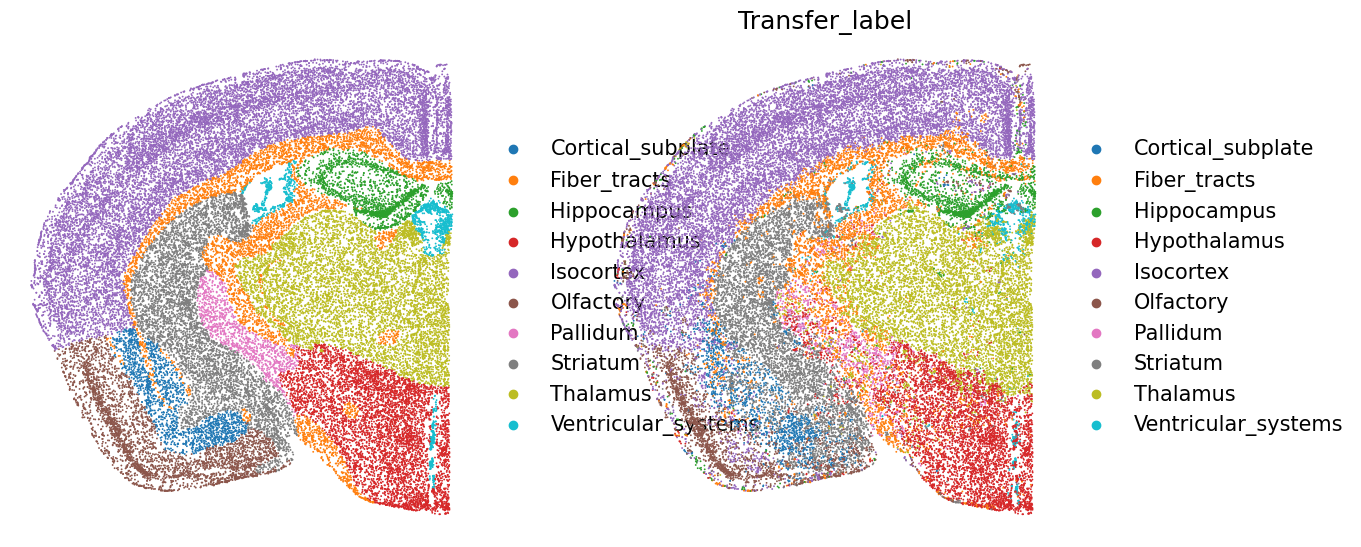

In [23]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata1, basis="spatial",s=7,color=['major_brain_region','Transfer_label'],colorbar_loc=None,title='',frameon=False)

In [24]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata1.obs['major_brain_region'])
cluster_labels = np.array(adata1.obs['Transfer_label'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.710557284934337
NMI: 0.6138223621100551
AMI: 0.6136402452542661
FMI: 0.7588032882173189
V-Measure: 0.6138223621100553
Homogeneity: 0.6063830593608361


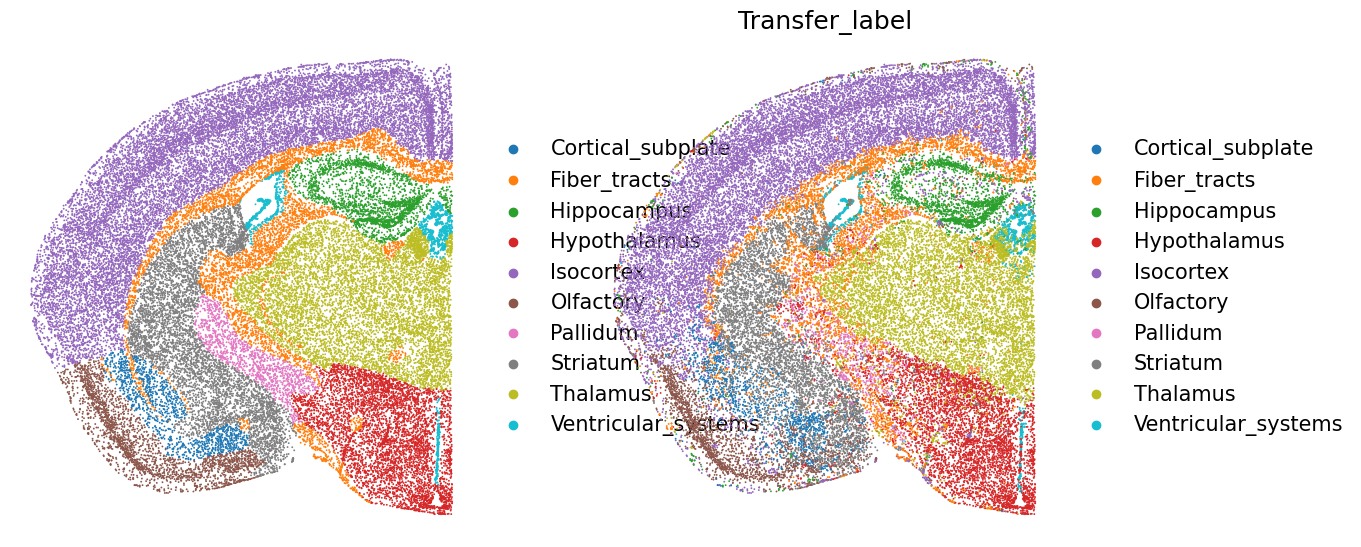

In [25]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (6,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata2, basis="spatial",s=7,color=['major_brain_region','Transfer_label'],colorbar_loc=None,title='',frameon=False)

In [26]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata2.obs['major_brain_region'])
cluster_labels = np.array(adata2.obs['Transfer_label'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.7223008289923929
NMI: 0.6140703479398285
AMI: 0.6138912313676854
FMI: 0.7700977746579892
V-Measure: 0.6140703479398286
Homogeneity: 0.6112665150914275


In [27]:
adata1.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/Transfer1.h5ad',compression='gzip')
adata2.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/setting3/Transfer2.h5ad',compression='gzip')